# LSTM Sign Language Detection 


**LSTM MODEL**
1. Install and import dependencies
2. Keypoints using MP Holistic
3. Extract Keypoints
4. Setup Folders for Collection
5. Collect Keypoints Values for Training and Testing
6. Preprocess Data and Create Labels and Features
7. Build and Train LSTM Neural Network
8. Make Predictions
9. Save Weights
10. Evaluation using Confusion Matrix and Accuracy
11. Test in Real Time

# Install and Import Dependencies

In [11]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib tensorflowjs

In [13]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [14]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [15]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR-CONVERSION BGR-to-RGB
    image.flags.writeable = False                  # Convert image to not-writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Convert image to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR-COVERSION RGB-to-BGR
    return image, results

In [16]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [17]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [18]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # Show to screen
#         cv2.imshow('OpenCV Feed', image)

#         # Break gracefully
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

In [7]:
# draw_landmarks(frame, results)

In [19]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [20]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Setup Folders for Collection

In [22]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Hello', 'Bye', 'Thank_you'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [23]:
signs = ['Hello', 'Bye', 'Thank_you']

parent_folder = 'MP_Data'

if not os.path.exists(parent_folder):
    os.mkdir(parent_folder)
    for sign in signs:
        sign_folder = os.path.join(parent_folder, sign)
        os.mkdir(sign_folder)
        for i in range(30):
            subfolder = os.path.join(sign_folder, str(i))
            os.mkdir(subfolder)


# Collect Keypoint Values for Training and Testing

In [24]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [25]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [27]:
label_map = {label:num for num, label in enumerate(actions)}

In [28]:
label_map

{'Hello': 0, 'Bye': 1, 'Thank_you': 2}

In [29]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [30]:
X = np.array(sequences)

In [31]:
y = to_categorical(labels).astype(int)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Build and Train LSTM Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [34]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
#While training access tensorboard
#tensorboard --logdir=.

In [35]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [36]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000


3/3 [==============================] - 4s 69ms/step - loss: 1.3869 - categorical_accuracy: 0.3412
Epoch 2/2000
3/3 [==============================] - 0s 58ms/step - loss: 4.5268 - categorical_accuracy: 0.2824
Epoch 3/2000
3/3 [==============================] - 0s 62ms/step - loss: 2.8362 - categorical_accuracy: 0.3882
Epoch 4/2000
3/3 [==============================] - 0s 67ms/step - loss: 2.1313 - categorical_accuracy: 0.3059
Epoch 5/2000
3/3 [==============================] - 0s 96ms/step - loss: 1.5960 - categorical_accuracy: 0.3176
Epoch 6/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.2917 - categorical_accuracy: 0.2941
Epoch 7/2000
3/3 [==============================] - 0s 67ms/step - loss: 1.7800 - categorical_accuracy: 0.3059
Epoch 8/2000
3/3 [==============================] - 0s 65ms/step - loss: 1.1128 - categorical_accuracy: 0.3765
Epoch 9/2000
3/3 [==============================] - 0s 68ms/step - loss: 1.1671 - categorical_accuracy: 0.2471

3/3 [==============================] - 0s 87ms/step - loss: 1.3590e-06 - categorical_accuracy: 1.0000
Epoch 429/2000
3/3 [==============================] - 0s 93ms/step - loss: 1.3562e-06 - categorical_accuracy: 1.0000
Epoch 430/2000
3/3 [==============================] - 0s 85ms/step - loss: 1.3478e-06 - categorical_accuracy: 1.0000
Epoch 431/2000
3/3 [==============================] - 0s 82ms/step - loss: 1.3379e-06 - categorical_accuracy: 1.0000
Epoch 432/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.3323e-06 - categorical_accuracy: 1.0000
Epoch 433/2000
3/3 [==============================] - 0s 84ms/step - loss: 1.3253e-06 - categorical_accuracy: 1.0000
Epoch 434/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.3211e-06 - categorical_accuracy: 1.0000
Epoch 435/2000
3/3 [==============================] - 0s 84ms/step - loss: 1.3155e-06 - categorical_accuracy: 1.0000
Epoch 436/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.30

Epoch 498/2000
3/3 [==============================] - 0s 100ms/step - loss: 9.6489e-07 - categorical_accuracy: 1.0000
Epoch 499/2000
3/3 [==============================] - 0s 94ms/step - loss: 9.6209e-07 - categorical_accuracy: 1.0000
Epoch 500/2000
3/3 [==============================] - 0s 89ms/step - loss: 9.5648e-07 - categorical_accuracy: 1.0000
Epoch 501/2000
3/3 [==============================] - 0s 96ms/step - loss: 9.5227e-07 - categorical_accuracy: 1.0000
Epoch 502/2000
3/3 [==============================] - 0s 97ms/step - loss: 9.4526e-07 - categorical_accuracy: 1.0000
Epoch 503/2000
3/3 [==============================] - 0s 95ms/step - loss: 9.4245e-07 - categorical_accuracy: 1.0000
Epoch 504/2000
3/3 [==============================] - 0s 85ms/step - loss: 9.4105e-07 - categorical_accuracy: 1.0000
Epoch 505/2000
3/3 [==============================] - 0s 96ms/step - loss: 9.3404e-07 - categorical_accuracy: 1.0000
Epoch 506/2000
3/3 [==============================] - 0s 99ms/s

3/3 [==============================] - 0s 95ms/step - loss: 5.3714e-07 - categorical_accuracy: 1.0000
Epoch 638/2000
3/3 [==============================] - 0s 95ms/step - loss: 5.3714e-07 - categorical_accuracy: 1.0000
Epoch 639/2000
3/3 [==============================] - 0s 95ms/step - loss: 5.3714e-07 - categorical_accuracy: 1.0000
Epoch 640/2000
3/3 [==============================] - 0s 93ms/step - loss: 5.3434e-07 - categorical_accuracy: 1.0000
Epoch 641/2000
3/3 [==============================] - 0s 98ms/step - loss: 5.3294e-07 - categorical_accuracy: 1.0000
Epoch 642/2000
3/3 [==============================] - 0s 101ms/step - loss: 5.3294e-07 - categorical_accuracy: 1.0000
Epoch 643/2000
3/3 [==============================] - 0s 98ms/step - loss: 5.3294e-07 - categorical_accuracy: 1.0000
Epoch 644/2000
3/3 [==============================] - 0s 96ms/step - loss: 5.3153e-07 - categorical_accuracy: 1.0000
Epoch 645/2000
3/3 [==============================] - 0s 99ms/step - loss: 5.2

3/3 [==============================] - 0s 118ms/step - loss: 4.2354e-07 - categorical_accuracy: 1.0000
Epoch 708/2000
3/3 [==============================] - 0s 95ms/step - loss: 4.2074e-07 - categorical_accuracy: 1.0000
Epoch 709/2000
3/3 [==============================] - 0s 87ms/step - loss: 4.2074e-07 - categorical_accuracy: 1.0000
Epoch 710/2000
3/3 [==============================] - 0s 119ms/step - loss: 4.1934e-07 - categorical_accuracy: 1.0000
Epoch 711/2000
3/3 [==============================] - 0s 104ms/step - loss: 4.1793e-07 - categorical_accuracy: 1.0000
Epoch 712/2000
3/3 [==============================] - 0s 98ms/step - loss: 4.1513e-07 - categorical_accuracy: 1.0000
Epoch 713/2000
3/3 [==============================] - 0s 105ms/step - loss: 4.1513e-07 - categorical_accuracy: 1.0000
Epoch 714/2000
3/3 [==============================] - 0s 87ms/step - loss: 4.1513e-07 - categorical_accuracy: 1.0000
Epoch 715/2000
3/3 [==============================] - 0s 123ms/step - loss:

3/3 [==============================] - 0s 83ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 847/2000
3/3 [==============================] - 0s 84ms/step - loss: 2.5385e-07 - categorical_accuracy: 1.0000
Epoch 848/2000
3/3 [==============================] - 0s 86ms/step - loss: 2.5385e-07 - categorical_accuracy: 1.0000
Epoch 849/2000
3/3 [==============================] - 0s 83ms/step - loss: 2.5244e-07 - categorical_accuracy: 1.0000
Epoch 850/2000
3/3 [==============================] - 0s 82ms/step - loss: 2.5244e-07 - categorical_accuracy: 1.0000
Epoch 851/2000
3/3 [==============================] - 0s 81ms/step - loss: 2.5244e-07 - categorical_accuracy: 1.0000
Epoch 852/2000
3/3 [==============================] - 0s 82ms/step - loss: 2.5244e-07 - categorical_accuracy: 1.0000
Epoch 853/2000
3/3 [==============================] - 0s 83ms/step - loss: 2.5244e-07 - categorical_accuracy: 1.0000
Epoch 854/2000
3/3 [==============================] - 0s 84ms/step - loss: 2.52

3/3 [==============================] - 0s 86ms/step - loss: 5.3294e-08 - categorical_accuracy: 1.0000
Epoch 987/2000
3/3 [==============================] - 0s 88ms/step - loss: 5.1891e-08 - categorical_accuracy: 1.0000
Epoch 988/2000
3/3 [==============================] - 0s 88ms/step - loss: 5.0489e-08 - categorical_accuracy: 1.0000
Epoch 989/2000
3/3 [==============================] - 0s 85ms/step - loss: 4.7684e-08 - categorical_accuracy: 1.0000
Epoch 990/2000
3/3 [==============================] - 0s 85ms/step - loss: 4.6281e-08 - categorical_accuracy: 1.0000
Epoch 991/2000
3/3 [==============================] - 0s 83ms/step - loss: 4.6281e-08 - categorical_accuracy: 1.0000
Epoch 992/2000
3/3 [==============================] - 0s 85ms/step - loss: 4.6281e-08 - categorical_accuracy: 1.0000
Epoch 993/2000
3/3 [==============================] - 0s 87ms/step - loss: 4.4879e-08 - categorical_accuracy: 1.0000
Epoch 994/2000
3/3 [==============================] - 0s 87ms/step - loss: 4.20

3/3 [==============================] - 0s 87ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1125/2000
3/3 [==============================] - 0s 87ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1126/2000
3/3 [==============================] - 0s 86ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1127/2000
3/3 [==============================] - 0s 85ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1128/2000
3/3 [==============================] - 0s 88ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1129/2000
3/3 [==============================] - 0s 87ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1130/2000
3/3 [==============================] - 0s 89ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1131/2000
3/3 [==============================] - 0s 85ms/step - loss: 2.8049e-09 - categorical_accuracy: 1.0000
Epoch 1132/2000
3/3 [==============================] - 0s 86ms/step - lo

3/3 [==============================] - 0s 101ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 1263/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 1264/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1265/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1266/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1267/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1268/2000
3/3 [==============================] - 0s 96ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 1269/2000
3/3 [==============================] - 0s 92ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 1270/2000
3/3 [==============================] - 0s 99ms/step - 

3/3 [==============================] - 0s 100ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1401/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1402/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1403/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1404/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1405/2000
3/3 [==============================] - 0s 93ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 1406/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1407/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1408/2000
3/3 [==============================] - 0s 88ms/step - l

3/3 [==============================] - 0s 101ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1539/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1540/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1541/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1542/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1543/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1544/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1545/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1546/2000
3/3 [==============================] - 0s 95ms/step - 

3/3 [==============================] - 0s 139ms/step - loss: 1.4025e-09 - categorical_accuracy: 1.0000
Epoch 1677/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1678/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1679/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1680/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1681/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1682/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1683/2000
3/3 [==============================] - 0s 116ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1684/2000
3/3 [==============================] - 0s 133ms/step 

3/3 [==============================] - 0s 113ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1815/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1816/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1817/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1818/2000
3/3 [==============================] - 0s 85ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1819/2000
3/3 [==============================] - 0s 83ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1820/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1821/2000
3/3 [==============================] - 0s 125ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1822/2000
3/3 [==============================] - 0s 129ms/step -

3/3 [==============================] - 0s 86ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1953/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1954/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1955/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1956/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1957/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1958/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1959/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 1960/2000
3/3 [==============================] - 0s 79ms/step - lo

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

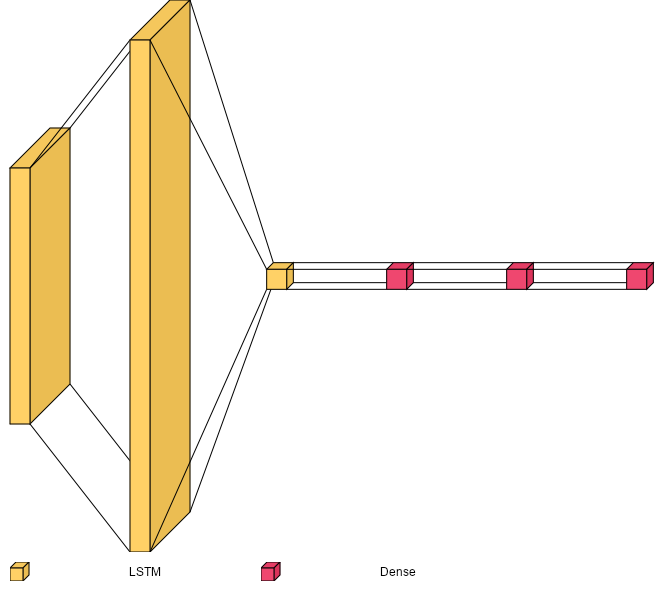

In [27]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font,spacing=100)

# Make Predictions

In [28]:
res = model.predict(X_test)

1/1 [==============================] - 1s 553ms/step


In [29]:
actions[np.argmax(res[4])]

'food'

In [30]:
actions[np.argmax(y_test[4])]

'food'

# Save Weights

In [31]:
model.save('./model.h5')
model.save_weights('./model_weights.h5');

In [ ]:
del model

In [32]:
import tensorflow as tf
model = tf.keras.models.load_model('model.h5')

In [33]:
model.load_weights('model_weights.h5')

# Evaluation using Confusion Matrix

In [34]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [35]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 515ms/step


In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [37]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [38]:
accuracy_score(ytrue, yhat)

1.0

# Realtime Test

In [39]:
from scipy import stats

In [40]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [42]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [ ]:
!pip install numpy --upgrade

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

signs = ['hello', 'thanks', 'iloveyou']
actions = np.array(['hello', 'thanks', 'iloveyou'])


mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR-CONVERSION BGR-to-RGB
    image.flags.writeable = False                  # Convert image to not-writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Convert image to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR-COVERSION RGB-to-BGR
    return image, results

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])
    
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

model = tf.keras.models.load_model('model.h5')
model.load_weights('model_weights.h5')
model.summary()

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        #print(sentence)
        #word = sentence[-1:]
        #convert_to_audio(word[0]) if (len(word) != 0) else print("word not detected yet")
        #convert_to_audio(word[0])
        
        # Show to screen
        cv2.imshow('Realtime LSTM Sign Language Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()